In [ ]:
import json
import pandas as pd
from pathlib import Path

import json
import pandas as pd
from pathlib import Path

def stream_jsonl_to_parquet(jsonl_path, output_folder, batch_size=10000):
    buffer = []
    batch_num = 0

    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)

    print(f"Processing {jsonl_path}...")

    with open(jsonl_path, "r") as f:
        for i, line in enumerate(f):
            try:
                obj = json.loads(line)
                if obj.get("label") in [0, 1]:
                    buffer.append(obj)

                if len(buffer) >= batch_size:
                    df = pd.DataFrame(buffer)
                    output_path = output_folder / f"batch_{batch_num}.parquet"
                    df.to_parquet(output_path, index=False, engine="pyarrow", compression='snappy')
                    print(f"  Saved batch {batch_num} with {len(df)} rows to {output_path}")
                    buffer.clear()
                    batch_num += 1

                    break

            except json.JSONDecodeError as e:
                print(f"  Skipping line {i} due to JSON error: {e}")

    # Save any leftover rows
    if buffer:
        df = pd.DataFrame(buffer)
        output_path = output_folder / f"batch_{batch_num}.parquet"
        df.to_parquet(output_path, index=False, engine="pyarrow", compression='snappy')
        print(f"  Saved final batch {batch_num} with {len(df)} rows to {output_path}")

    print(f"Finished processing {jsonl_path}")


# Open and process the JSONL file
input_file = "F://ember//train_features_1.jsonl"
output_dir = "F://ember//parquet_batches"

stream_jsonl_to_parquet(input_file, output_dir)




In [ ]:
#df = pd.read_parquet("F://ember2018//parquet_batches_0//batch_0.parquet")
df = pd.read_parquet("F://ember//parquet_batches//batch_0.parquet")
row = df.iloc[0]

print(df.columns.tolist())
print(row["header"]["optional"].keys())

In [ ]:
import matplotlib.pyplot as plt

df["label"].value_counts().plot(kind="bar", title="Malware vs Benign Distribution")
plt.xticks(ticks=[0, 1], labels=["Benign (0)", "Malware (1)"])
plt.ylabel("Count")
plt.show()

In [ ]:
print(df.columns.tolist())
print(df.iloc[0])

In [4]:
from feature_extractors.pe_feature import PEFeatureExtractor


path = "C://Users//Alisa//Desktop//Unity app//CatKyu!! v3//CatKyu!!.exe"
with open(path, "rb") as f:
    bytez = f.read()
extractor = PEFeatureExtractor()

# Extract the raw feature dict
raw = extractor.raw_features(bytez)

# Turn it into a flat vector (normalized)
vector = extractor.process_raw_features(raw)

print("Feature vector shape:", vector.shape)
print("SHA256 of file:", raw['sha256'])
print("Extracted features: ", raw['imports'])
print("First 10 values of vector:", vector[:100])

Feature vector shape: (2351,)
SHA256 of file: 7bc58a214bb9c0f06a1ee0a7a3a0524f81653caf160b7084861ea6c6c8fd4e21
Extracted features:  {'UnityPlayer.dll': ['UnityMain'], 'KERNEL32.dll': ['HeapAlloc', 'WriteConsoleW', 'QueryPerformanceCounter', 'GetCurrentProcessId', 'GetCurrentThreadId', 'GetSystemTimeAsFileTime', 'InitializeSListHead', 'RtlCaptureContext', 'RtlLookupFunctionEntry', 'RtlVirtualUnwind', 'IsDebuggerPresent', 'UnhandledExceptionFilter', 'SetUnhandledExceptionFilter', 'GetStartupInfoW', 'IsProcessorFeaturePresent', 'GetModuleHandleW', 'CloseHandle', 'RtlUnwindEx', 'GetLastError', 'SetLastError', 'EnterCriticalSection', 'LeaveCriticalSection', 'DeleteCriticalSection', 'InitializeCriticalSectionAndSpinCount', 'TlsAlloc', 'TlsGetValue', 'TlsSetValue', 'TlsFree', 'FreeLibrary', 'GetProcAddress', 'LoadLibraryExW', 'EncodePointer', 'RaiseException', 'RtlPcToFileHeader', 'GetStdHandle', 'WriteFile', 'GetModuleFileNameW', 'GetCurrentProcess', 'ExitProcess', 'TerminateProcess', 'GetMo

In [16]:
import feature_extractors
data_dir = "F://ember_dataset//ember"

#feature_extractors.create_vectorized_features(data_dir)
X_train, y_train, X_test, y_test = feature_extractors.read_vectorized_features(data_dir)


In [1]:
import numpy as np
print(np.__version__)


1.26.4


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

class DNN(nn.Module):
    def __init__(self, input_dim=2351):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
import feature_extractors
data_dir = "F://ember"

X, y = feature_extractors.read_vectorized_features(data_dir)
i, j, k = 0, 600000, 800000  

X_train = X[i:j]
y_train = y[i:j]

X_test = X[j:k]
y_test = y[j:k]


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (600000, 2351)
y_train shape: (600000,)
X_test shape: (200000, 2351)
y_test shape: (200000,)


In [32]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X_train[300000:400000], y_train[300000:400000], test_size=0.2, random_state=19, stratify=y_train[300000:400000])

In [33]:
print(X1_train.shape, y1_train.shape)
count_ones = int((y1_train[0:80000] == 1).sum())
print(count_ones)

(80000, 2351) (80000,)
41127


In [18]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch

# Assuming you already have X_train, y_train as numpy arrays, you can create a DataLoader

# Convert your data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()  # Assuming X_train is a NumPy array
y_train_tensor = torch.from_numpy(y_train).float()  # Assuming y_train is a NumPy array

# Create a TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 8192  # Choose an appropriate batch size that doesn't overload your RAM
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

C:\Users\Alisa\AppData\Local\Temp\ipykernel_11340\3669718633.py:8: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  X_train_tensor = torch.from_numpy(X_train).float()  # Assuming X_train is a NumPy array


In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # much safer LR (not 0.1!)
criterion = nn.BCELoss()

num_epochs = 2000
loss_values = []
acc_values = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch_idx, (xb, yb) in enumerate(train_loader):
        xb = xb.to(device)  # move input to GPU
        yb = yb.to(device)
    
        optimizer.zero_grad()
        preds = model(xb)
        
        loss = criterion(preds, yb.unsqueeze(1))  # important: use raw preds for loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds_rounded = preds.round()
        correct_preds += (preds_rounded == yb.unsqueeze(1)).sum().item()
        total_preds += yb.size(0)

        # compute batch accuracy
        batch_acc = (preds_rounded == yb.unsqueeze(1)).float().mean().item()

        # Print per batch
        #print(f"Batch {batch_idx+1}/{len(train_loader)} — Loss: {loss.item():.4f}, Batch Acc: {batch_acc:.4f}")

    # Epoch summary
    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_preds / total_preds

    # Save loss and accuracy
    if (epoch + 1) % 10 == 0:
        loss_values.append(avg_loss)
        acc_values.append(avg_acc)

    # Print every 100 epochs
    if (epoch + 1) % 10 == 0:
        print(f"[Epoch {epoch+1}] Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")


[Epoch 10] Avg Loss: 0.4627, Avg Acc: 0.7790
[Epoch 20] Avg Loss: 0.4233, Avg Acc: 0.8025
[Epoch 30] Avg Loss: 0.4029, Avg Acc: 0.8175
[Epoch 40] Avg Loss: 0.3496, Avg Acc: 0.8471
[Epoch 50] Avg Loss: 0.3147, Avg Acc: 0.8679
[Epoch 60] Avg Loss: 0.2837, Avg Acc: 0.8840
[Epoch 70] Avg Loss: 0.2675, Avg Acc: 0.8923
[Epoch 80] Avg Loss: 0.2433, Avg Acc: 0.9034
[Epoch 90] Avg Loss: 0.2271, Avg Acc: 0.9104
[Epoch 100] Avg Loss: 0.2212, Avg Acc: 0.9131
[Epoch 110] Avg Loss: 0.2147, Avg Acc: 0.9156
[Epoch 120] Avg Loss: 0.1999, Avg Acc: 0.9223
[Epoch 130] Avg Loss: 0.1910, Avg Acc: 0.9252
[Epoch 140] Avg Loss: 0.1900, Avg Acc: 0.9264
[Epoch 150] Avg Loss: 0.1864, Avg Acc: 0.9275
[Epoch 160] Avg Loss: 0.1771, Avg Acc: 0.9313
[Epoch 170] Avg Loss: 0.1742, Avg Acc: 0.9324
[Epoch 180] Avg Loss: 0.1701, Avg Acc: 0.9348
[Epoch 190] Avg Loss: 0.1736, Avg Acc: 0.9333
[Epoch 200] Avg Loss: 0.1608, Avg Acc: 0.9385
[Epoch 210] Avg Loss: 0.1573, Avg Acc: 0.9397
[Epoch 220] Avg Loss: 0.1532, Avg Acc: 0.94

KeyboardInterrupt: 

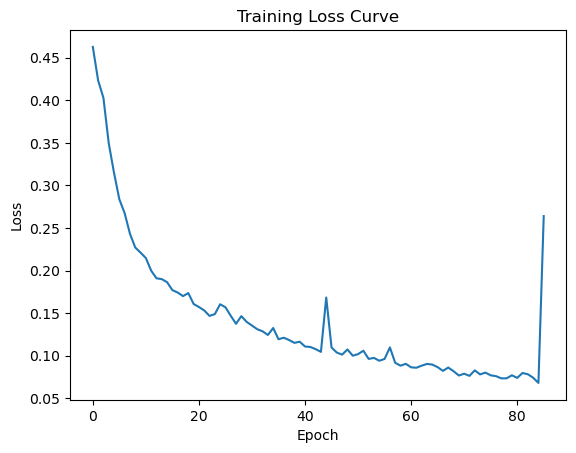

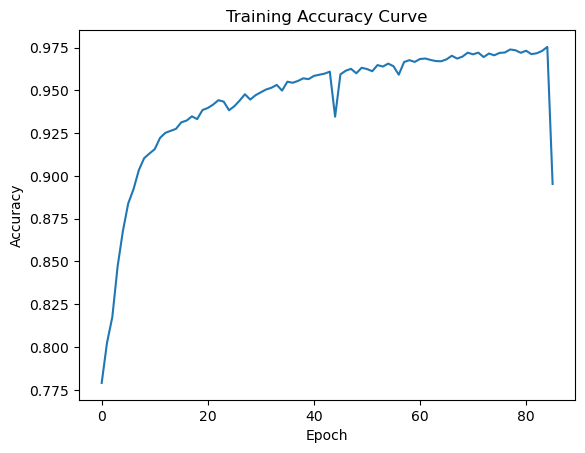

In [20]:
from typing import List
import matplotlib.pyplot as plt
def plot_loss(loss_values: List[float]):
    plt.plot(loss_values)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()
    
def plot_acc(acc_values: List[float]):
    plt.plot(acc_values)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Curve')
    plt.show()

plot_loss(loss_values)
plot_acc(acc_values)

In [21]:
torch.save(model.state_dict(), "dnn_model2.pth")

In [32]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DNN().to(device)
model.load_state_dict(torch.load("dnn_model.pth"))
print(model)

DNN(
  (net): Sequential(
    (0): Linear(in_features=2351, out_features=1024, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=128, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


In [8]:
import numpy as np

#np.savez("test_data1.npz", X_test=X1_test, y_test=y1_test)

# Load later
data = np.load("test_data.npz")
X_test_loaded = data["X_test"]
y_test_loaded = data["y_test"]

print(X_test_loaded.shape)

(20000, 2351)


In [33]:
from torch.utils.data import TensorDataset, DataLoader

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=8192, shuffle=False)


In [34]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        probs = model(xb).squeeze()  # probs are between 0 and 1 due to sigmoid
        all_probs.append(probs.cpu().numpy())
        all_labels.append(yb.cpu().numpy())

# Concatenate
all_probs = np.concatenate(all_probs)
all_labels = np.concatenate(all_labels)


AUC Score: 0.5716


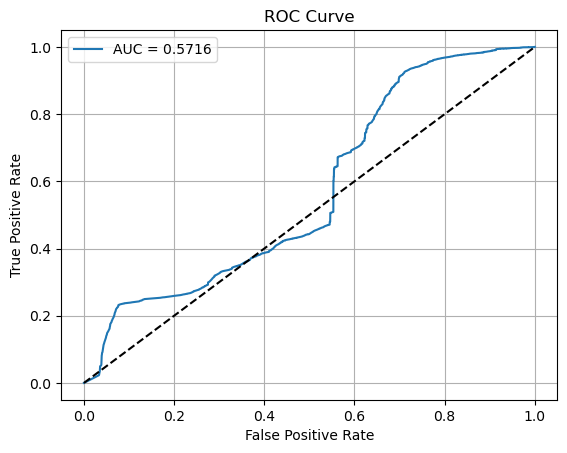

In [35]:
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
auc_score = roc_auc_score(all_labels, all_probs)

print(f"AUC Score: {auc_score:.4f}")

# Optionally: plot the ROC curve
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert probabilities to binary predictions
y_pred = (all_probs >= 0.5).astype(int)

print("Accuracy :", accuracy_score(all_labels, y_pred))
print("Precision:", precision_score(all_labels, y_pred))
print("Recall   :", recall_score(all_labels, y_pred))
print("F1 Score :", f1_score(all_labels, y_pred))


Accuracy : 0.606465
Precision: 0.5647026649244887
Recall   : 0.92919
F1 Score : 0.7024816193842257


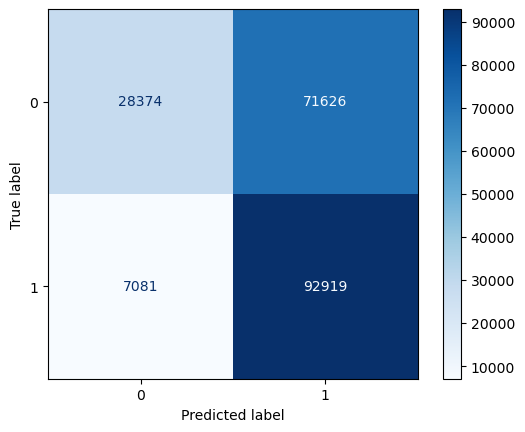

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')


In [48]:
import torch
import lief

from feature_extractors.pe_feature import PEFeatureExtractor
from feature_extractors.pe_feature import ImportsInfo

path = "D://SteamLibrary//steamapps//common//No Man's Sky//Binaries//NMS.exe"
with open(path, "rb") as f:
    bytez = f.read()
extractor = ImportsInfo()

try:
    lief_binary = lief.PE.parse(list(bytez)) 
except Exception as e:
    print(f"Failed to parse with LIEF: {e}")
    lief_binary = None

# Extract the raw feature dict
raw = extractor.raw_features(bytez, lief_binary)

# Turn it into a flat vector (normalized)
vector = extractor.process_raw_features(raw)

print("Feature vector shape:", vector.shape)
#print("SHA256 of file:", raw['sha256'])
#print("Extracted features: ", raw['imports'])
print("First 500 values of vector:", vector[:500])

# Make sure your model is in eval mode
'''model.eval()

# Convert the file to a tensor and move to GPU (if used)
file_tensor = torch.tensor(vector, dtype=torch.float32).unsqueeze(0).to(device)  # shape: [1, 2351]

# Get the predicted probability
with torch.no_grad():
    prob = model(file_tensor).item()

print(f"Probability of being malicious: {prob * 100:.2f}%")

# Optionally get binary label
label = 1 if prob > 0.5 else 0
print(f"Predicted label: {'malicious' if label else 'benign'}")'''


Feature vector shape: (1280,)
First 500 values of vector: [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -2.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0. -1.  0. -1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0. -1.  0.  0.  0.
  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0. -1.  1.  0.  0.  0. -1.  0. -1.  0.  0.  0.  0.  0.
 -1. -1.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. -1. -1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -1.
  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 -1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. -1.  0.  1.  0.
 -2.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 -1.  0.  0.  1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0. -1.  

'model.eval()\n\n# Convert the file to a tensor and move to GPU (if used)\nfile_tensor = torch.tensor(vector, dtype=torch.float32).unsqueeze(0).to(device)  # shape: [1, 2351]\n\n# Get the predicted probability\nwith torch.no_grad():\n    prob = model(file_tensor).item()\n\nprint(f"Probability of being malicious: {prob * 100:.2f}%")\n\n# Optionally get binary label\nlabel = 1 if prob > 0.5 else 0\nprint(f"Predicted label: {\'malicious\' if label else \'benign\'}")'